# Spectrometer accuracy assesment using validation tarps

## Background

In this lesson we will be examing the accuracy of the Neon Imaging Spectrometer (NIS) against targets with known reflectance. The targets consist of two 10 x 10 m tarps which have been specially designed to have 3% reflectance (black tarp) and 48% reflectance (white tarp) across all of the wavelengths collected by the NIS (see images below). During the Sept. 12 2016 flight over the Chequamegon-Nicolet National Forest, an area in D05 which is part of Steigerwaldt (STEI) site, these tarps were deployed in a gravel pit. During the airborne overflight, observations were also taken over the tarps with an ASD field spectrometer. The ASD measurments provide a validation source against the the airborne measurements. 

![Reflectance tarps](IMG_0396.JPG)
![Reflectance tarps](IMG_0400.JPG)
![Reflectance tarps](aerial_tarps.jpg)

To test the accuracy, we will utilize reflectance curves from the tarps as well as from the associated flight line and execute absolute and relative comparisons. The major error sources in the NIS can be generally categorized into the following sources

1) Calibration of the sensor

2) Quality of ortho-rectification

3) Accuracy of radiative transfer code and subsequent ATCOR interpolation

4) Selection of atmospheric input parameters

5) Terrain relief

6) Terrain cover

Note that the manual for ATCOR, the atmospheric correction software used by AOP, specifies the accuracy of reflectance retrievals to be between 3 and 5% of total reflectance. The tarps are located in a flat area, therefore, influences by terrain releif should be minimal. We will ahve to keep the remining errors in mind as we analyze the data. 


## Objective
 
In this lesson we will learn how to retrieve relfectance curves from a pre-specified coordainte in a NEON AOP HDF 5 file, learn how to read a tab delimited text file, retrieve bad band window indexes and mask portions of a reflectance curve, plot reflectance curves on a graph and save the file, gain an understanding of some sources of uncertainty in NIS data.

## Suggested pre-requisites

Working with NEON AOP Hyperspectral Data in Python Jupyter Notebooks

Learn to Efficiently Process NEON Hyperspectral Data

We'll start by adding all of the necessary libraries to our python script


In [2]:
import h5py
import csv
import numpy as np
import os
import gdal
import matplotlib.pyplot as plt
import sys
from math import floor
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

As well as our function to read the hdf5 reflectance files and associated metadata

In [3]:
def h5refl2array(h5_filename):
    hdf5_file = h5py.File(h5_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN\n",
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)\n",
    mapInfo_split = mapInfo_string.split(",")
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]
    #Extract the upper left-hand corner coordinates from mapInfo\n",
    xMin = float(mapInfo_split[3]) #convert from string to floating point number\n",
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions\n",
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth'])) #xMax = left edge + (# of columns * resolution)\n",
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) #yMin = top edge - (# of rows * resolution)\n",
    metadata['extent'] = (xMin,xMax,yMin,yMax),
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    return reflArray, metadata, wavelengths

Define the location where you are holding the data for the data institute. The h5_filename will be the flightline which contains the tarps, and the tarp_48_filename and tarp_03_filename contain the field validated spectra for the white and black tarp respectively, organized by wavelength and reflectance.

In [4]:
print('Start CHEQ tarp uncertainty script')

h5_filename = 'C:/RSDI_2017/data/CHEQ/H5/NEON_D05_CHEQ_DP1_20160912_160540_reflectance.h5'
tarp_48_filename = 'C:/RSDI_2017/data/CHEQ/H5/CHEQ_Tarp_48_01_refl_bavg.txt'
tarp_03_filename = 'C:/RSDI_2017/data/CHEQ/H5/CHEQ_Tarp_03_02_refl_bavg.txt'


Start CHEQ tarp uncertainty script


We want to pull the spectra from the airborne data from the center of the tarp to minimize any errors introduced by infiltrating light in adjecent pixels, or through errors in ortho-rectification (source 2). We have pre-determined the coordinates for the center of each tarp which are as follows:

48% reflectance tarp UTMx: 727487, UTMy: 5078970

3% reflectance tarp UTMx: 727497, UTMy: 5078970

![Reflectance tarp centers](tarp_centers.JPG)

Let's define these coordaintes

In [5]:
tarp_48_center = np.array([727487,5078970])
tarp_03_center = np.array([727497,5078970])

Now we'll use our function designed for NEON AOP's HDF5 files to access the hyperspectral data

In [6]:
[reflArray,metadata,wavelengths] = h5refl2array(h5_filename)

Within the reflectance curves there are areas with noisey data due to atmospheric windows in the water absorption bands. For this exercise we do not want to plot these areas as they obscure detailes in the plots due to their anamolous values. The meta data assocaited with these band locations is contained in the metadata gatherd by our function. We will pull out these areas as 'bad band windows' and determine which indexes in the reflectance curves contain the bad bands

In [7]:
bad_band_window1 = (metadata['bad_band_window1'])
bad_band_window2 = (metadata['bad_band_window2'])

index_bad_window1 = [i for i, x in enumerate(wavelengths) if x > bad_band_window1[0] and x < bad_band_window1[1]]
index_bad_window2 = [i for i, x in enumerate(wavelengths) if x > bad_band_window2[0] and x < bad_band_window2[1]]


Now join the list of indexes together into a single variable

In [8]:
index_bad_windows = index_bad_window1+index_bad_window2

The reflectance data is saved in files which are 'tab delimited.' We will use a numpy function (genfromtxt) to quickly import the tarp reflectance curves observed with the ASD using the '\t' delimeter to indicate tabs are used.

In [9]:
tarp_48_data = np.genfromtxt(tarp_48_filename, delimiter = '\t')
tarp_03_data = np.genfromtxt(tarp_03_filename, delimiter = '\t')

Now we'll set all the data inside of those windows to NaNs (not a number) so they will not be included in the plots

In [10]:
tarp_48_data[index_bad_windows] = np.nan
tarp_03_data[index_bad_windows] = np.nan

The next step is to determine which pixel in the reflectance data belongs to the center of each tarp. To do this, we will subtract the tarp center pixel location from the upper left corner pixels specified in the map info of the H5 file. This information is saved in the metadata dictionary output from our function that reads NEON AOP HDF5 files. The difference between these coordaintes gives us the x and y index of the reflectance curve. 

In [11]:
x_tarp_48_index = int((tarp_48_center[0] - metadata['ext_dict']['xMin'])/float(metadata['res']['pixelWidth']))
y_tarp_48_index = int((metadata['ext_dict']['yMax'] - tarp_48_center[1])/float(metadata['res']['pixelHeight']))

x_tarp_03_index = int((tarp_03_center[0] - metadata['ext_dict']['xMin'])/float(metadata['res']['pixelWidth']))
y_tarp_03_index = int((metadata['ext_dict']['yMax'] - tarp_03_center[1])/float(metadata['res']['pixelHeight']))

Next, we will plot both the curve from the airborne data taken at the center of the tarps as well as the curves obtained from the ASD data to provide a visualisation of their consistency for both tarps. Once generated, we will also save the figure to a pre-determined location.

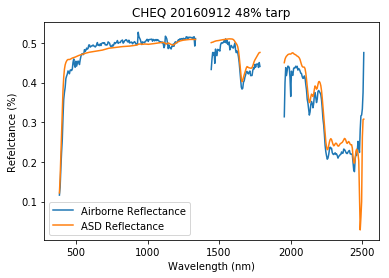

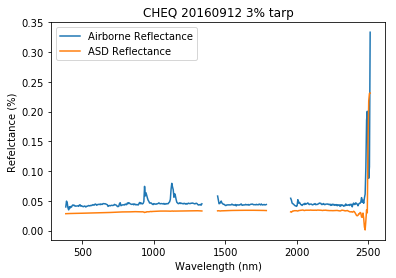

In [14]:
plt.figure(1)
tarp_48_reflectance = np.asarray(reflArray[y_tarp_48_index,x_tarp_48_index,:], dtype=np.float32)/metadata['scaleFactor']
tarp_48_reflectance[index_bad_windows] = np.nan
plt.plot(wavelengths,tarp_48_reflectance,label = 'Airborne Reflectance')
plt.plot(wavelengths,tarp_48_data[:,1], label = 'ASD Reflectance')
plt.title('CHEQ 20160912 48% tarp')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Refelctance (%)')
plt.legend()
plt.savefig('CHEQ_20160912_48_tarp.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(2)
tarp_03_reflectance = np.asarray(reflArray[y_tarp_03_index,x_tarp_03_index,:], dtype=np.float32)/ metadata['scaleFactor']
tarp_03_reflectance[index_bad_windows] = np.nan
plt.plot(wavelengths,tarp_03_reflectance,label = 'Airborne Reflectance')
plt.plot(wavelengths,tarp_03_data[:,1],label = 'ASD Reflectance')
plt.title('CHEQ 20160912 3% tarp')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Refelctance (%)')
plt.legend()
plt.savefig('CHEQ_20160912_3_tarp.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)





This produces plots showing the results of the ASD and airborne measurements over the 48% tarp. Visually, the comparison between the two appears to be fairly good. However, over the 3% tarp we appear to be over-estimating the reflectance. Large absolute differences could be associated with ATCOR input parameters (source 4). For example, the user must input the local visibility, which is related to aerosal optical thickness (AOT). We don't measure this at every site, therefore input a standard parameter for all sites. 

Given the 3% reflectance tarp has much lower overall reflactance, it may be more informative to determine what the absolute difference between the two curves are and plot that as well.

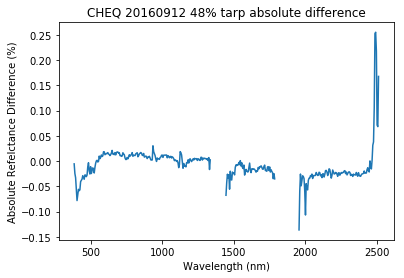

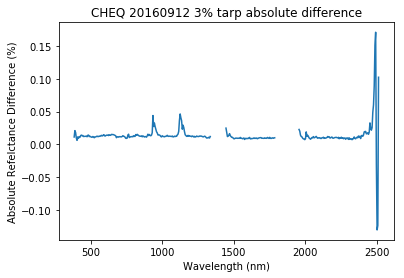

In [15]:
plt.figure(3)
plt.plot(wavelengths,tarp_48_reflectance-tarp_48_data[:,1])
plt.title('CHEQ 20160912 48% tarp absolute difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absolute Refelctance Difference (%)')
plt.savefig('CHEQ_20160912_48_tarp_absolute_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(4)
plt.plot(wavelengths,tarp_03_reflectance-tarp_03_data[:,1])
plt.title('CHEQ 20160912 3% tarp absolute difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absolute Refelctance Difference (%)')
plt.savefig('CHEQ_20160912_3_tarp_absolute_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)




From this we are able to see that the 48% tarp actually has larger absolute differences than the 3% tarp. The 48% tarp performs poorly at the shortest and longest waveleghts as well as near the edges of the 'bad band windows.' This is related to difficulty in calibrating the sensor in these sensitive areas (source 1).

Let's now determine the result of the percent difference, which is the metric used by ATCOR to report accuracy. We can do this by calculating the ratio of the absolute difference between curves to the total reflectance 



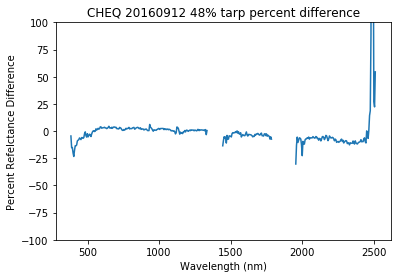

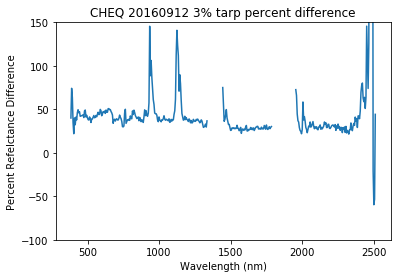

In [16]:

plt.figure(5)
plt.plot(wavelengths,100*np.divide(tarp_48_reflectance-tarp_48_data[:,1],tarp_48_data[:,1]))
plt.title('CHEQ 20160912 48% tarp percent difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Percent Refelctance Difference')
plt.ylim((-100,100))
plt.savefig('CHEQ_20160912_48_tarp_relative_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

plt.figure(6)
plt.plot(wavelengths,100*np.divide(tarp_03_reflectance-tarp_03_data[:,1],tarp_03_data[:,1]))
plt.title('CHEQ 20160912 3% tarp percent difference')
plt.xlabel('Wavelength (nm)'); plt.ylabel('Percent Refelctance Difference')
plt.ylim((-100,150))
plt.savefig('CHEQ_20160912_3_tarp_relative_diff.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)




From these plots we can see that even though the absolute error on the 48% tarp was larger, the relative error on the 48% tarp is generally much smaller. The 3% tarp can have errors exceeding 50% for most of the tarp. This indicates that targets with low reflectance values may have higher relative errors.

